In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import skimage
from skimage import io
import os
import glob
import numpy as np
from skimage import exposure, measure
from skimage.transform import rotate
from skimage.measure import compare_ssim as ssim
import re
from torch.utils.data import Dataset
from cellvision_lib import get_model_data_splits
import pickle
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/gpfs/share/skynet/apps/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
def dir_to_file_lists(directory):
    os.chdir(directory)
    input_list = []
    target_list = []
    all_tifs = glob.glob("*.tif")
    input_tifs = [file for file in all_tifs if '_channel1_' in file]
    input_tifs.sort()
    output_tifs = [file for file in all_tifs if '_channel6_' in file]
    output_tifs.sort()
    return(input_tifs, output_tifs)

In [4]:
# for small dataset to overfit
input_tifs, output_tifs = dir_to_file_lists('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50')

In [5]:
train, test, val = get_model_data_splits('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50', 
                                      channel = 1, 
                                      train_pp = .67, 
                                      test_pp = .165, 
                                      val_pp = .165, 
                                      seed = 1)

In [6]:
def image_to_matrix_dataset(file_list, augmentation=False):
    """
    funciton takes list of file names and returns list of matrices
    list will be 6 times as long since data is flipped + rotated too
    params:
    augmentation: augment original training data with flips and rotations. Returns 6 times as many images.
    """
    
    mat_list = []
    for file in file_list:
        orig = io.imread(file)
        mat_list.append(orig)
        
        if augmentation:
            #vertical flip
            vert_flip = orig[::-1]
            mat_list.append(vert_flip)

            #horizonal flip
            horiz_flip = np.flip(orig,1)
            mat_list.append(horiz_flip)

            #rotate 90 degrees
            rot_90 = rotate(orig, 90)
            mat_list.append(rot_90)

            #rotate 180 degrees
            rot_180 = rotate(orig, 180)
            mat_list.append(rot_180)

            #rotate 270 degrees
            rot_270 = rotate(orig, 270)
            mat_list.append(rot_270)
    return(mat_list)

In [14]:
# small dataset
input_tifs_mats = image_to_matrix_dataset(input_tifs[:100])
output_tifs_mats = image_to_matrix_dataset(output_tifs[:100])

#full dataset
#train_input = image_to_matrix_dataset(list(x[0] for x in train))
#train_target = image_to_matrix_dataset(list(x[1] for x in train))
#
val_input = image_to_matrix_dataset(list(x[0] for x in val))
val_target = image_to_matrix_dataset(list(x[1] for x in val))
#
#test_input = image_to_matrix_dataset(list(x[0] for x in test))
#test_target = image_to_matrix_dataset(list(x[1] for x in test))

single_test_input = val_input[0]
single_test_target = val_target[0] 

# write to pickle

# read from pickle

In [7]:
class two_image_dataset(Dataset):
    
    def __init__(self, input_tifs_mats, output_tifs_mats):
        
        self.input_tifs_mats = input_tifs_mats
        self.output_tifs_mats = output_tifs_mats
        assert (len(self.input_tifs_mats) == len(self.output_tifs_mats))
    
    def __len__(self):
        return len(self.input_tifs_mats)
    
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        input_mat = self.input_tifs_mats[key]
        output_mat = self.output_tifs_mats[key]
        return [input_mat, output_mat]

In [8]:
def two_image_collate_func(batch):
    """
    function that returns input and target as tensors
    """
    input_list = []
    target_list = []
    for datum in batch:
        input_list.append(datum[0].astype(dtype = 'float32')/32768)
        target_list.append(datum[1].astype(dtype = 'float32')/32768)
    input_tensor = torch.from_numpy(np.array(input_list))
    target_tensor = torch.from_numpy(np.array(target_list))
    return input_tensor, target_tensor

In [19]:
BATCH_SIZE = 4

# all is the mini set to develop with
all_dataset = two_image_dataset(input_tifs_mats, output_tifs_mats)
all_loader = torch.utils.data.DataLoader(dataset=all_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=two_image_collate_func,
                                           shuffle=False)

# train
#train_dataset = two_image_dataset(train_input, train_target)
#train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
#                                           batch_size=BATCH_SIZE,
#                                           collate_fn=two_image_collate_func,
#                                           shuffle=False)
## val
#val_dataset = two_image_dataset(val_input, val_target)
#val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
#                                           batch_size=BATCH_SIZE,
#                                           collate_fn=two_image_collate_func,
#                                           shuffle=False)
## test
#test_dataset = two_image_dataset(test_input, test_target)
#test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                           batch_size=BATCH_SIZE,
#                                           collate_fn=two_image_collate_func,
#                                           shuffle=False)

single_test_dataset = two_image_dataset(single_test_input, single_test_target)
single_test_loader = torch.utils.data.DataLoader(dataset=single_test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=two_image_collate_func,
                                           shuffle=False)


In [9]:
# unet parts here

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [10]:
# UNET arch here
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x = x.view(x.size(0), 1, 512, 512).to(device)
        #print(x.shape)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.sigmoid(x)

In [11]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    returns average ssim for loader
    @param: loader - data loader for the dataset to test against
    """
    ssim_list = []
    nmse_list = []
    model.eval()
    for inputs, targets in loader:
        outputs = model(inputs)
        # to cpu
        cur_out = outputs.cpu()
        cur_tar = targets.cpu()
        # get ssim for each pair
        for i in range(outputs.shape[0]):
            sing_out = (cur_out.data.numpy()[i,0,:,:]*32768 // 1).astype(np.int16)
            sing_tar = (cur_tar.data.numpy()[i,:,:]*32768 // 1).astype(np.int16)
            cur_ssim = ssim(sing_tar, sing_out, data_range=sing_out.max() - sing_out.min())
            sing_out = np.array(sing_out, dtype='int64')
            sing_tar = np.array(sing_tar, dtype='int64')
            cur_nmse = (np.abs(np.square(sing_tar - sing_out))).mean(axis=None) / (np.square(sing_tar - 0)).mean(axis=None)
            ssim_list.append(cur_ssim)
            nmse_list.append(cur_nmse)
    ssim_avg = sum(ssim_list) / len(ssim_list)
    ssim_std = np.std(ssim_list)
    nmse_avg = sum(nmse_list) / len(nmse_list)
    nmse_std = np.std(nmse_list)
    
    return (ssim_avg, ssim_std, nmse_avg, nmse_std)


In [ ]:
model = UNet(1, 1)
model = model.to(device)

In [124]:
learning_rate = 0.0005
num_epochs = 20

# Criterion and Optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [125]:
os.chdir('/home/cra354')
filename = 'test.txt'

for epoch in range(num_epochs): 
    for i, (inputs, targets) in enumerate(all_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1,1,512,512).to(device))
        # Backward and optimize
        loss.backward()
        optimizer.step()
        if i > 0 and i % 20 == 0:
            print("Epoch: {}, Step : {}".format(epoch, i))
            print("Training Loss : {}".format(loss))
            val_ssim, val_ssim_std, nmse_avg, nmse_std = test_model(all_loader, model)
            print("Validation SSIM: {},Validation SSIM Standard Deviation: {} ".format(val_ssim, val_ssim_std))
            print("Validation MSE: {}, Validation MSE Standard Deviation: {}".format(nmse_avg, nmse_std))
            # write to file so can see streaming...
            file = open(filename, "a")
            file.write("Epoch: {}, Step : {} \n".format(epoch, i))
            file.write("Training Loss : {} \n".format(loss))
            file.write("Validation SSIM: {},Validation SSIM Standard Deviation: {} \n".format(val_ssim, val_ssim_std))
            file.write("Validation MSE: {}, Validation MSE Standard Deviation: {} \n".format(nmse_avg, nmse_std))
            file.close()
            # save model each step
            #modelname = 'model_' + str(RUN_CHANNEL) + '_'+ str(NUM_IMAGES) +'.p'
            #pickle.dump(model, open(modelname, "wb" ))

Epoch: 0, Step : 20
Training Loss : 0.10218680649995804
Validation SSIM: 0.007691161806672886,Validation SSIM Standard Deviation: 0.000345462397191149 
Validation MSE: 18.28523431274539, Validation MSE Standard Deviation: 3.4356396148137076
Epoch: 1, Step : 20
Training Loss : 0.0786655843257904
Validation SSIM: 0.12343540761598332,Validation SSIM Standard Deviation: 0.00852888661742862 
Validation MSE: 12.116103131037612, Validation MSE Standard Deviation: 2.341876400793609
Epoch: 2, Step : 20
Training Loss : 0.0662691742181778
Validation SSIM: 0.1628293183412228,Validation SSIM Standard Deviation: 0.005996294143312904 
Validation MSE: 7.538041534920548, Validation MSE Standard Deviation: 1.4344949929390967
Epoch: 3, Step : 20
Training Loss : 0.04807877168059349


/gpfs/share/skynet/apps/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in short_scalars


Validation SSIM: 0.14306292019589562,Validation SSIM Standard Deviation: 0.18909722087042383 
Validation MSE: 5.602042794274282, Validation MSE Standard Deviation: 0.8335522664167893
Epoch: 4, Step : 20
Training Loss : 0.03477367013692856


KeyboardInterrupt: 

In [17]:
RUN_CHANNEL = 1
os.chdir('/home/cra354')
modelname = 'model_' + str(RUN_CHANNEL) + '.p'
pickle.dump(model, open( modelname, "wb" ) )

In [108]:
out_list = []
tar_list = []

for epoch in range(num_epochs): 
    for i, (inputs, targets) in enumerate(all_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1,1,512,512).to(device))
        # Backward and optimize
        loss.backward()
        optimizer.step()
        if i > 0 and i % 20 == 0:
            print(epoch)
            
            model.eval()
            val_ssim = test_model(all_loader, model)
            print("Validation SSIM: {}".format(val_ssim))
            cur_out = outputs.cpu()
            cur_tar = targets.cpu()
            # get single image from batch
            sing_out = (cur_out.data.numpy()[0,0,:,:]*32768 // 1).astype(np.int16)
            sing_tar = (cur_tar.data.numpy()[0,:,:]*32768 // 1).astype(np.int16)
            # append to list
            out_list.append(sing_out)
            tar_list.append(sing_tar)

/opt/DL/pytorch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/opt/DL/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0


KeyboardInterrupt: 

In [19]:
full_list = out_list

In [20]:
out_list = full_list[::1]

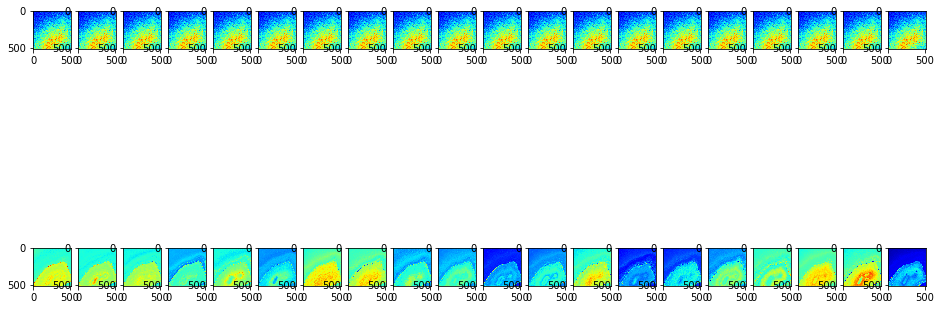

In [21]:
fig, axes = plt.subplots(2, len(out_list), figsize=(16, 8))#, sharex=True, sharey=True)
ax = axes.ravel()

for i in range(len(out_list)):
    ax[i].imshow(tar_list[i], cmap='jet')
for i in range(len(out_list)):
    ax[i+len(out_list)].imshow(out_list[i], cmap='jet')
plt.show()

In [22]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(model_parameters)
print(params)

13394177


In [23]:
out_list

[array([[1275, 1684, 1733, ..., 1954, 1987, 1642],
        [1549, 1718, 1694, ..., 1848, 1828, 1848],
        [1659, 1880, 1802, ..., 1951, 1901, 1890],
        ...,
        [1549, 1921, 1928, ..., 1892, 1833, 1753],
        [1421, 1869, 1849, ..., 1800, 1752, 1712],
        [1152, 1593, 1614, ..., 1944, 1882, 1705]], dtype=int16),
 array([[1140, 1568, 1639, ..., 1798, 1882, 1448],
        [1427, 1615, 1675, ..., 1796, 1813, 1727],
        [1524, 1732, 1745, ..., 1864, 1832, 1720],
        ...,
        [1477, 2119, 2325, ..., 1858, 1816, 1646],
        [1355, 2131, 2172, ..., 1787, 1799, 1674],
        [1075, 1504, 1573, ..., 1839, 1803, 1554]], dtype=int16),
 array([[1205, 1620, 1634, ..., 1838, 1956, 1503],
        [1510, 1655, 1551, ..., 1729, 1781, 1705],
        [1629, 1789, 1623, ..., 1772, 1814, 1699],
        ...,
        [1454, 2141, 2237, ..., 1864, 1807, 1561],
        [1415, 2197, 2126, ..., 1771, 1765, 1568],
        [1112, 1565, 1565, ..., 1753, 1685, 1403]], dtype=int16)

In [24]:
# load models 1-5 and test
os.chdir('/home/cra354')
model_1 = pickle.load( open( "model_1.p", "rb" ) )
model_2 = pickle.load( open( "model_2.p", "rb" ) )
model_3 = pickle.load( open( "model_3.p", "rb" ) )
model_4 = pickle.load( open( "model_4.p", "rb" ) )
model_5 = pickle.load( open( "model_5.p", "rb" ) )

model_list = [model_1,
            model_2,
            model_3,
            model_4,
            model_5]

In [25]:
test_model(loader=test_loader, model=model_3)

NameError: name 'test_loader' is not defined

In [127]:
def get_ssim_nmse_orig(loader):
    ssim_list = []
    nmse_list = []
    for inputs, targets in loader:
        cur_out = inputs.cpu()
        cur_tar = targets.cpu()
        # get ssim for each pair
        for i in range(inputs.shape[0]):
            #print(cur_out.data.numpy()[i])
            #print(cur_tar.data.numpy()[i])
            sing_out = (cur_out.data.numpy()[i]*32768 // 1).astype(np.int16)
            sing_tar = (cur_tar.data.numpy()[i]*32768 // 1).astype(np.int16)
            #print(sing_out == sing_tar)
            cur_ssim = ssim(sing_tar, sing_out, data_range=(sing_out.max() - sing_out.min()))
            #print(cur_ssim)
            sing_out = np.array(sing_out, dtype='int64')
            sing_tar = np.array(sing_tar, dtype='int64')
            cur_nmse = (np.abs(np.square(sing_tar - sing_out))).mean(axis=None) / (np.square(sing_tar - 0)).mean(axis=None)
            #print(cur_nmse)
            ssim_list.append(cur_ssim)
            nmse_list.append(cur_nmse)
    ssim_avg = sum(ssim_list) / len(ssim_list)
    ssim_std = np.std(ssim_list)
    nmse_avg = sum(nmse_list) / len(nmse_list)
    nmse_std = np.std(nmse_list)
    
    return (ssim_avg, ssim_std, nmse_avg, nmse_std)

In [126]:
train, test, val = get_model_data_splits('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50', 
                                          channel = channel, 
                                          train_pp = .67, 
                                          test_pp = .165, 
                                          val_pp = .165, 
                                          seed = 1)
val_input = image_to_matrix_dataset(list(x[0] for x in val))
val_target = image_to_matrix_dataset(list(x[1] for x in val))
val_dataset = two_image_dataset(val_input, val_target)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=two_image_collate_func,
                                           shuffle=False)

In [128]:
print(get_ssim_nmse_orig(val_loader))

(0.02227966944562705, 0.013718100514093128, 0.7811956872901828, 0.03091226666557633)


In [130]:
channel_list = [1,2,3,4,5]
for channel in channel_list:
    train, test, val = get_model_data_splits('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50', 
                                          channel = channel, 
                                          train_pp = .67, 
                                          test_pp = .165, 
                                          val_pp = .165, 
                                          seed = 1)
    val_input = image_to_matrix_dataset(list(x[0] for x in val))
    val_target = image_to_matrix_dataset(list(x[1] for x in val))
    val_dataset = two_image_dataset(val_input, val_target)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=two_image_collate_func,
                                               shuffle=False)
    print(get_ssim_nmse_orig(val_loader))

(0.02227966944562705, 0.013718100514093128, 0.7811956872901828, 0.03091226666557633)
(0.04004126293771672, 0.025023946340376767, 0.718703593768004, 0.03460533902503676)
(0.3744573130906787, 0.13768481659650753, 0.24514785291683938, 0.021285165097689244)
(0.5745193565500439, 0.16474886224241161, 0.046872663802475734, 0.00905198829622059)
(0.6350055677121377, 0.16292997928902211, 0.008479559198575584, 0.002400736845490537)


In [106]:
for i, (inputs, targets) in enumerate(val_loader):
    print(inputs==targets)
    

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]], dtype=torch.uint8)
tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
       

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]], dtype=torch.uint8)
tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
       

KeyboardInterrupt: 

[array([[209, 128, 170, ..., 168, 180, 200],
        [184, 172, 184, ..., 160, 165, 172],
        [157, 174, 191, ..., 185, 215, 226],
        ...,
        [235, 310, 223, ..., 243, 192, 227],
        [233, 196, 261, ..., 262, 274, 291],
        [260, 217, 260, ..., 221, 221, 227]], dtype=uint16),
 array([[188, 217, 161, ..., 202, 185, 190],
        [151, 193, 167, ..., 198, 190, 186],
        [151, 196, 201, ..., 185, 187, 163],
        ...,
        [217, 284, 259, ..., 209, 278, 210],
        [242, 245, 248, ..., 273, 222, 197],
        [168, 240, 231, ..., 214, 209, 260]], dtype=uint16),
 array([[160, 166, 202, ..., 221, 220, 207],
        [163, 199, 157, ..., 198, 195, 218],
        [168, 172, 163, ..., 158, 217, 202],
        ...,
        [247, 241, 211, ..., 287, 266, 289],
        [229, 226, 222, ..., 305, 244, 215],
        [201, 183, 275, ..., 227, 257, 273]], dtype=uint16),
 array([[172, 195, 178, ..., 172, 225, 229],
        [161, 185, 197, ..., 261, 236, 182],
        [180,

In [20]:
def single_test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    returns average ssim for loader
    @param: loader - data loader for the dataset to test against
    """
    model.eval()
    for inputs, targets in loader:
        outputs = model(inputs)
        # to cpu
        cur_out = outputs.cpu()
        cur_tar = targets.cpu()
        # get ssim for each pair
        for i in range(outputs.shape[0]):
            sing_out = (cur_out.data.numpy()[i,0,:,:]*32768 // 1).astype(np.int16)
    return(sing_out)

In [16]:

os.chdir('/home/cra354/')
model = torch.load('model_1.p', map_location=lambda storage, loc: storage)
#out_image = single_test_model(single_test_loader, model)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location='cpu' to map your storages to the CPU.

In [24]:
imshow(out_image)

NameError: name 'out_image' is not defined

In [26]:
model

NameError: name 'model' is not defined